In [286]:
# ДЗ
# 1. Подберите параметры алгоритма разрастания регионов так, чтобы был выделен весь участок газона.
# 2. Реализуйте вычисление критерия однородности, отличного от представленного. Сравните результаты.
# 3. Применить алгоритм сегментации watershed+distance transform для задачи подсчета пальмовых деревьев.

In [287]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

Чтение картинки

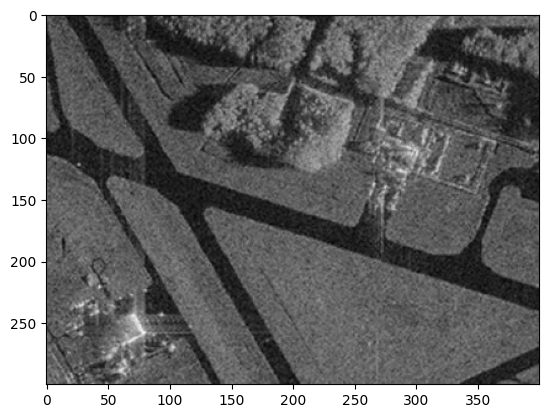

In [288]:
image = cv2.imread('sar_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image_gray, cmap="gray")

Гистограмма яркости

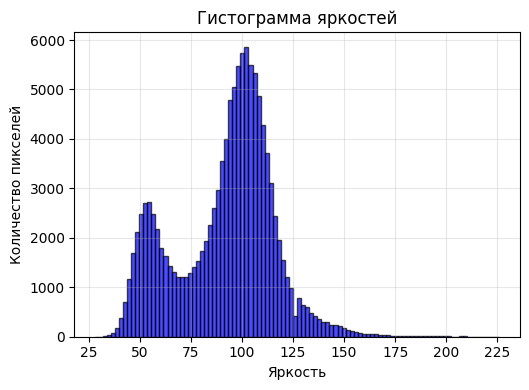

In [289]:
def simple_histogram(image, mask=None, title="Гистограмма яркостей"):
    if mask is not None:
        pixels = image[mask > 0]
    else:
        pixels = image.flatten()
    
    plt.figure(figsize=(10, 4))
    
    plt.subplot(121)
    plt.hist(pixels, bins=100, alpha=0.7, color='blue', edgecolor='black')
    plt.xlabel('Яркость')
    plt.ylabel('Количество пикселей')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

simple_histogram(image_gray)

Критерий однородности (отклонение любого пикселя от средней яркости T)

In [290]:
import math
def homo_average(img, mask, point, T):
    av_val = np.mean(img[mask > 0])                                                    
    return abs(av_val - img[point]) <= T
    


Алгоритм разрастания регионов

In [291]:
def region_growing(image, seed_point, homo_fun, r, T):
    mask = np.zeros(image_gray.shape, np.uint8)
    mask[seed_point] = 1
    count = 1
    while count > 0:
        count = 0
        local_mask = np.zeros(image_gray.shape, np.uint8)
        for i in range(r,image.shape[0] - r):
            for j in range(r,image.shape[1] - r):
                if mask[i,j]==0 and mask[i - r:i + r, j-r: j+r].sum() > 0:
                    if homo_fun(image, mask, (i,j), T):
                        local_mask[i,j] = 1
        count = np.count_nonzero(local_mask)
        mask += local_mask
        
    return mask*255

In [292]:
result_imgs = {'Original': image_gray}

### 1. Подберите параметры алгоритма разрастания регионов так, чтобы был выделен весь участок газона.

In [293]:
def manual_parameter_test(image, seed, test_parameters):
    print("Start region growing with params...")
    
    for i, (r, t) in enumerate(test_parameters):
        print(f"\nRegion growing with homo_average {i+1}/{len(test_parameters)}: r={r}, T={t}")
        
        result_mask = region_growing(image, seed, homo_average, r, t)
        area = np.sum(result_mask > 0)
        
        plt.figure(figsize=(10, 4))
        
        plt.subplot(1, 3, 1)
        plt.imshow(image, cmap='gray')
        plt.title('Original')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(result_mask, cmap='gray')
        plt.title(f'r={r}, T={t}\nSquare: {area}px')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(image, cmap='gray')
        plt.imshow(result_mask, alpha=0.4, cmap='Reds')
        plt.title('Appling a mask')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
            

    
def quick_visual_test():
    test_parameters = [
        (1, 10),
        (2, 20), 
        (2, 30),
        (2, 35)
    ]
    
    image = image_gray
    seed = (250,250)
    
    return manual_parameter_test(image, seed, test_parameters)

Start region growing with params...

Region growing with homo_average 1/4: r=1, T=10


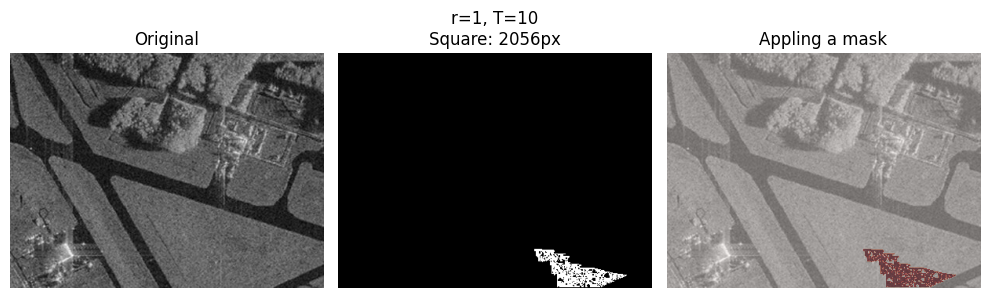


Region growing with homo_average 2/4: r=2, T=20


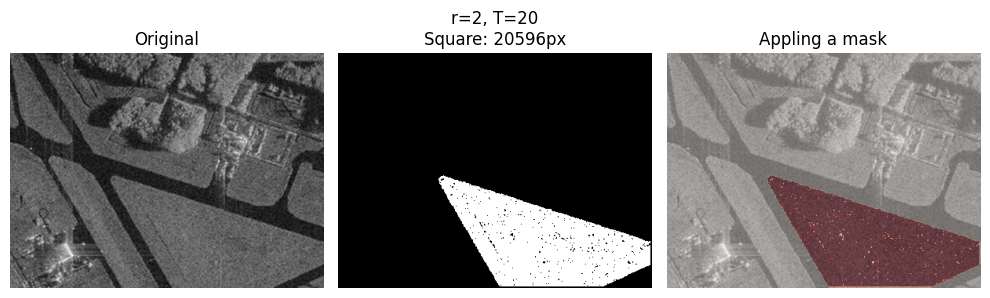


Region growing with homo_average 3/4: r=2, T=30


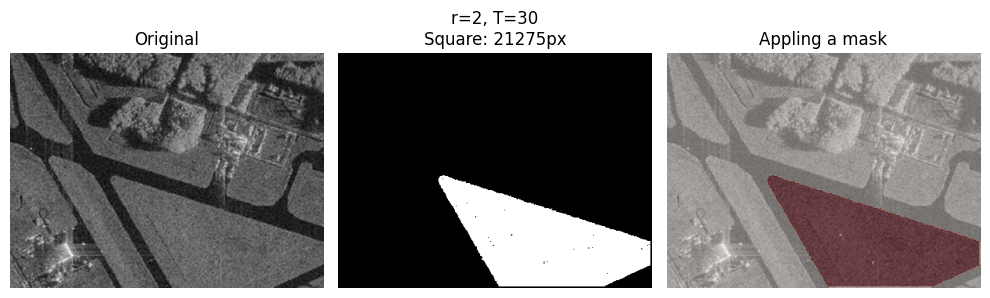


Region growing with homo_average 4/4: r=2, T=35


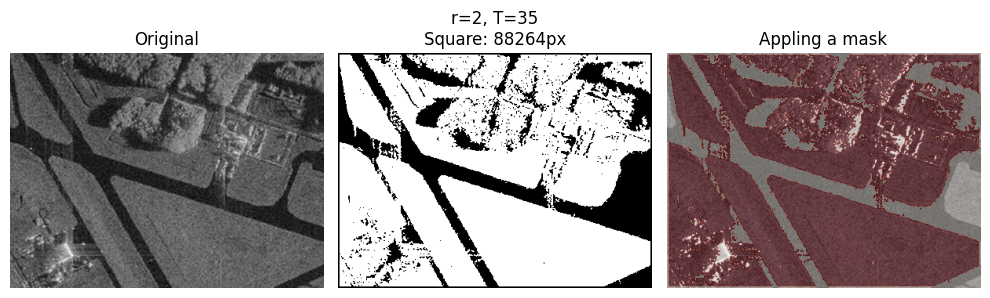

In [294]:
quick_visual_test()

### 2. Реализуйте вычисление критерия однородности, отличного от представленного. Сравните результаты.

Через KMeans

(np.float64(-0.5), np.float64(399.5), np.float64(299.5), np.float64(-0.5))

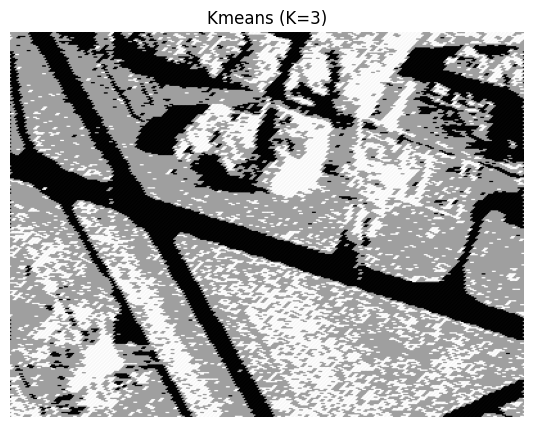

In [295]:
z = np.float32(image_gray.reshape((-1,3)))

K = 3
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.05) 

ret, label, center = cv2.kmeans(z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

center = np.uint8(center)
res = center[label.flatten()]
res = res.reshape((image_gray.shape))

fig, axs = plt.subplots(1, 1, figsize=(12, 5))

plt.imshow(res, cmap='gray')
plt.title(f'Kmeans (K={K})')
plt.axis('off')


Критерий разницы с 4-я соседями

In [296]:
def homo_neighbor_diff_4(img, mask, point, T):
    i, j = point
    height, width = img.shape
    
    current_val = img[i, j].astype(np.int32)
    for di, dj in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
        ni, nj = i + di, j + dj
        if 0 <= ni < height and 0 <= nj < width and mask[ni, nj] > 0:
            neighbor_val = img[ni, nj].astype(np.int32)
            if abs(current_val - neighbor_val) > T:
                return False
    return True

Критерий разницы с 8-ю соседями

In [297]:
def homo_neighbor_diff_8(img, mask, point, T):
    i, j = point
    height, width = img.shape
    
    current_val = img[i, j].astype(np.int32)
    for di, dj in [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, 1), (1, 0), (1, -1)]:
        ni, nj = i + di, j + dj
        if 0 <= ni < height and 0 <= nj < width and mask[ni, nj] > 0:
            neighbor_val = img[ni, nj].astype(np.int32)
            if abs(current_val - neighbor_val) > T:
                return False
    return True

Конфигурация для функций

In [308]:
criteria_config = {
    'average': (homo_average, {'T': 30}), # T - max variance average brightness
    'neighbor_diff_4': (homo_neighbor_diff_4, {'T': 17}), # T - allowed diff between neighbor
    'neighbor_diff_8': (homo_neighbor_diff_8, {'T': 20}), # T - allowed diff between neighbor
}

Словарь для хранения результатов эксперимента

In [309]:
result_imgs = {'Original': image_gray}

Применение функций в алгоритме разрастания регионов

In [310]:
seed = (250,250)
for name, (homo_fun, params) in criteria_config.items():
        T = params.get('T')
        mask = region_growing(image_gray, seed, homo_fun, r=2, T=T)
        result_imgs[f'{name} (r={2}, T={T})'] = mask
        print(f"{name}: square = {np.sum(mask > 0)} px")

average: square = 21275 px
neighbor_diff_4: square = 109840 px
neighbor_diff_8: square = 101106 px


Вывод результатов сравнения

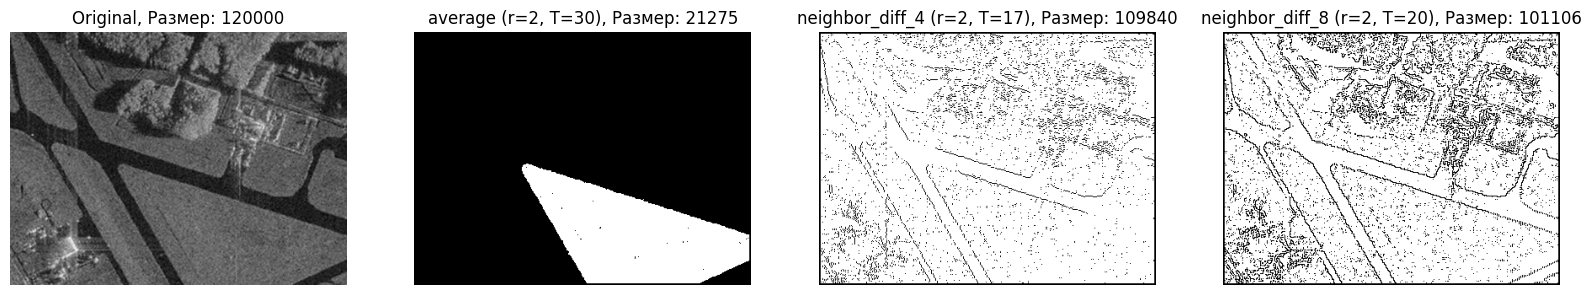

In [311]:
n_images = len(result_imgs)
fig, axes = plt.subplots(1, n_images, figsize=(5 * n_images, 10))

for idx, (name, mask) in enumerate(result_imgs.items()):
    axes[idx].imshow(mask, cmap='gray')
    axes[idx].set_title(f'{name}, Размер: {np.sum(mask > 0)}')
    axes[idx].axis('off')
    

### 3. Применить алгоритм сегментации watershed+distance transform для задачи подсчета пальмовых деревьев.

Читаем изображение

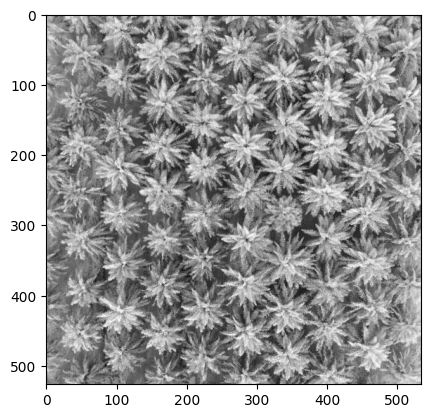

In [312]:
palm = cv2.imread("palm_1.JPG")
palm_gray = cv2.cvtColor(palm, cv2.COLOR_BGR2GRAY)
plt.imshow(palm_gray, cmap="gray")
plt.show()

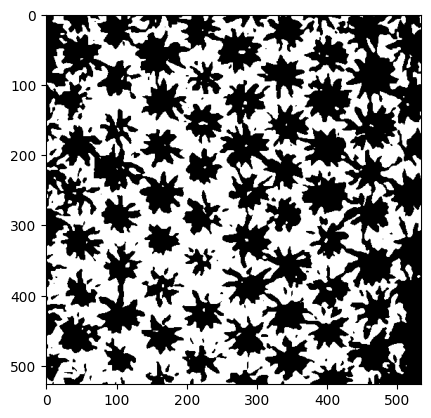

In [313]:
palm_gb = cv2.GaussianBlur(palm_gray, (9, 9), 0)
ret, thresh = cv2.threshold(palm_gb, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
plt.imshow(thresh, cmap="gray")

distance transform

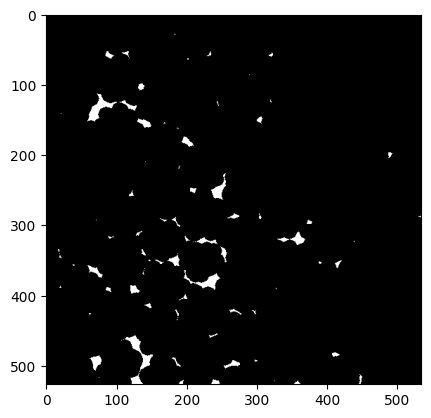

In [314]:
dist = cv2.distanceTransform(thresh, cv2.DIST_L2, 3) 
ret, sure_fg = cv2.threshold(dist, 0.6 * dist.max(), 255, cv2.THRESH_BINARY)
sure_fg = sure_fg.astype(np.uint8)
plt.imshow(sure_fg, cmap="gray")

+watershed

Palm count:  89


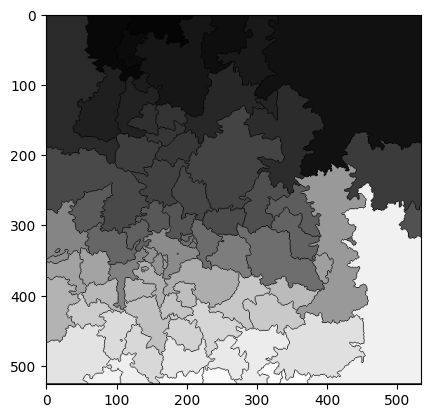

In [315]:
ret, mark = cv2.connectedComponents(sure_fg)
markers = cv2.watershed(palm, mark.astype(np.int32))
plt.imshow(markers, cmap="gray")
count = len(np.unique(markers)) - 1 # -background
print("Palm count: ", count)